In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
import sklearn
import re
import math
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForMaskedLM

from sklearn.metrics import (
    recall_score,
    precision_score
  )

from sklearn.metrics import multilabel_confusion_matrix

In [3]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [4]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [5]:
time_now = pd.Timestamp.now().strftime("%m-%d-%H-%M")
print(f"Time now: {time_now}")

Time now: 06-02-22-35


# Config

In [6]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'jackaduma/SecBERT'
        self.NUM_LABELS_TA = 14
        self.NUM_LABELS_TE = 185

        self.TOKENIZER = BertTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 50

In [7]:
TACTIC = ['TA0001', 'TA0002', 'TA0003', 'TA0004', 'TA0005', 'TA0006', 'TA0007', 'TA0008', 'TA0009', 'TA0010', 'TA0011', 'TA0040', 'TA0042', 'TA0043']
TECHNIQUE = ['T1001', 'T1003', 'T1005', 'T1006', 'T1007', 'T1008', 'T1010', 'T1011', 'T1012', 'T1014', 'T1016', 'T1018', 'T1020', 'T1021', 'T1025', 'T1027', 'T1029', 'T1030', 'T1033', 'T1036', 'T1037', 'T1039', 'T1040', 'T1041', 'T1046', 'T1047', 'T1048', 'T1049', 'T1052', 'T1053', 'T1055', 'T1056', 'T1057', 'T1059', 'T1068', 'T1069', 'T1071', 'T1072', 'T1074', 'T1078', 'T1080', 'T1082', 'T1083', 'T1087', 'T1090', 'T1091', 'T1092', 'T1095', 'T1098', 'T1102', 'T1104', 'T1105', 'T1106', 'T1110', 'T1111', 'T1112', 'T1113', 'T1114', 'T1115', 'T1119', 'T1120', 'T1123', 'T1124', 'T1125', 'T1127', 'T1129', 'T1132', 'T1133', 'T1134', 'T1135', 'T1136', 'T1137', 'T1140', 'T1176', 'T1185', 'T1187', 'T1189', 'T1190', 'T1195', 'T1197', 'T1199', 'T1200', 'T1201', 'T1202', 'T1203', 'T1204', 'T1205', 'T1207', 'T1210', 'T1211', 'T1212', 'T1213', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1482', 'T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1497', 'T1498', 'T1499', 'T1505', 'T1518', 'T1525', 'T1526', 'T1528', 'T1529', 'T1531', 'T1534', 'T1535', 'T1537', 'T1538', 'T1539', 'T1542', 'T1543', 'T1546', 'T1547', 'T1548', 'T1550', 'T1552', 'T1553', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1578', 'T1580', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598', 'T1599', 'T1600', 'T1601', 'T1602', 'T1606', 'T1608', 'T1609', 'T1610', 'T1611', 'T1612', 'T1613', 'T1614', 'T1615', 'T1619', 'T1620', 'T1621', 'T1622', 'T1647']
TACTICS_TECHNIQUES_RELATIONSHIP_DF = {
"TA0001":pd.Series(['T1078', 'T1091', 'T1133', 'T1189', 'T1190', 'T1195', 'T1199', 'T1200', 'T1566', 'T1659', 'T1669']),
"TA0002":pd.Series(['T1047', 'T1053', 'T1059', 'T1072', 'T1106', 'T1129', 'T1203', 'T1204', 'T1559', 'T1569', 'T1609', 'T1610', 'T1648', 'T1651', 'T1674', 'T1675']),
"TA0003":pd.Series(['T1037', 'T1053', 'T1078', 'T1098', 'T1112', 'T1133', 'T1136', 'T1137', 'T1176', 'T1197', 'T1205', 'T1505', 'T1525', 'T1542', 'T1543', 'T1546', 'T1547', 'T1554', 'T1556', 'T1574', 'T1653', 'T1668', 'T1671']),
"TA0004":pd.Series(['T1037', 'T1053', 'T1055', 'T1068', 'T1078', 'T1098', 'T1134', 'T1484', 'T1543', 'T1546', 'T1547', 'T1548', 'T1574', 'T1611']),
"TA0005":pd.Series(['T1006', 'T1014', 'T1027', 'T1036', 'T1055', 'T1070', 'T1078', 'T1112', 'T1127', 'T1134', 'T1140', 'T1197', 'T1202', 'T1205', 'T1207', 'T1211', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1484', 'T1497', 'T1535', 'T1542', 'T1548', 'T1550', 'T1553', 'T1556', 'T1562', 'T1564', 'T1574', 'T1578', 'T1599', 'T1600', 'T1601', 'T1610', 'T1612', 'T1620', 'T1622', 'T1647', 'T1656', 'T1666', 'T1672']),
"TA0006":pd.Series(['T1003', 'T1040', 'T1056', 'T1110', 'T1111', 'T1187', 'T1212', 'T1528', 'T1539', 'T1552', 'T1555', 'T1556', 'T1557', 'T1558', 'T1606', 'T1621', 'T1649']),
"TA0007":pd.Series(['T1007', 'T1010', 'T1012', 'T1016', 'T1018', 'T1033', 'T1040', 'T1046', 'T1049', 'T1057', 'T1069', 'T1082', 'T1083', 'T1087', 'T1120', 'T1124', 'T1135', 'T1201', 'T1217', 'T1482', 'T1497', 'T1518', 'T1526', 'T1538', 'T1580', 'T1613', 'T1614', 'T1615', 'T1619', 'T1622', 'T1652', 'T1654', 'T1673']),
"TA0008":pd.Series(['T1021', 'T1072', 'T1080', 'T1091', 'T1210', 'T1534', 'T1550', 'T1563', 'T1570']),
"TA0009":pd.Series(['T1005', 'T1025', 'T1039', 'T1056', 'T1074', 'T1113', 'T1114', 'T1115', 'T1119', 'T1123', 'T1125', 'T1185', 'T1213', 'T1530', 'T1557', 'T1560', 'T1602']),
"TA0010":pd.Series(['T1011', 'T1020', 'T1029', 'T1030', 'T1041', 'T1048', 'T1052', 'T1537', 'T1567']),
"TA0011":pd.Series(['T1001', 'T1008', 'T1071', 'T1090', 'T1092', 'T1095', 'T1102', 'T1104', 'T1105', 'T1132', 'T1205', 'T1219', 'T1568', 'T1571', 'T1572', 'T1573', 'T1659', 'T1665']),
"TA0040":pd.Series(['T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1498', 'T1499', 'T1529', 'T1531', 'T1561', 'T1565', 'T1657', 'T1667']),                
"TA0042":pd.Series(['T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1608', 'T1650']),
"TA0043":pd.Series(['T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'])
}

In [8]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

In [9]:
print(df_tactic_labels)

      TA0001  TA0002  TA0003  TA0004  TA0005  TA0006  TA0007  TA0008  TA0009  \
0          1       1       0       0       0       0       0       0       0   
1          1       1       0       0       0       0       0       0       0   
2          0       1       0       0       0       1       0       0       0   
3          1       1       0       0       0       0       0       0       0   
4          1       0       0       1       1       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1513       0       1       1       0       0       0       0       0       0   
1514       0       0       0       0       0       0       0       0       0   
1515       0       0       0       1       0       0       0       0       0   
1516       0       1       0       0       0       0       0       0       1   
1517       0       0       0       0       0       0       0       0       0   

      TA0010  TA0011  TA0040  TA0042  T

In [10]:
print(df_technique_labels)

      T1001  T1003  T1005  T1006  T1007  T1008  T1010  T1011  T1012  T1014  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      1      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1513      0      0      0      0      0      0      0      0      0      0   
1514      0      0      0      0      0      0      0      0      0      0   
1515      0      0      0      0      0      0      0      0      0      0   
1516      0      0      1      0      0      0      0      0      0      0   
1517      0      0      0      0      0      0      0      0      0      0   

      ...  T1611  T1612  T1613  T1614  T1615  T1619  T1620  T16

In [11]:
df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)


# Data processing

In [12]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [13]:
import nltk

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng"
]

for res in resources:
    try:
        nltk.data.find(res)
        print(f"{res} ✅ 已安裝")
    except LookupError:
        print(f"{res} ⛔ 未安裝，開始下載...")
        nltk.download(res)


punkt ⛔ 未安裝，開始下載...
stopwords ⛔ 未安裝，開始下載...
wordnet ⛔ 未安裝，開始下載...
omw-1.4 ⛔ 未安裝，開始下載...
averaged_perceptron_tagger ⛔ 未安裝，開始下載...
averaged_perceptron_tagger_eng ⛔ 未安裝，開始下載...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_t

In [14]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def ioc_sub(text):
    def reg_handler(obj):
        s = obj.group(1)
        s = ' '.join(s.split('\\'))
        return s

    def file_handler(obj):
        s = obj.group(2)
        s = s.split('\\')[-1]
        return s
    
    text = re.sub(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|\[\.\])){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\/([0-2][0-9]|3[0-2]|[0-9]))?', 'IPv4', text)
    text = re.sub(r'\b(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b', 'IP', text)
    text = re.sub(r'\b(CVE\-[0-9]{4}\-[0-9]{4,6})\b', 'CVE', text)
    text = re.sub(r'CVE-[0-9]{4}-[0-9]{4,6}', 'vulnerability', text)
    text = re.sub(r'\b([a-z][_a-z0-9-.]+@[a-z0-9-]+\.[a-z]+)\b', 'email', text)
    text = re.sub(r'\b((HKLM|HKCU|HKCR|HKU|HKCC)\\[\\A-Za-z0-9-_]+)\b', reg_handler, text)
    text = re.sub(r'\b([a-zA-Z]{1}:\\([0-9a-zA-Z_\.\-\/\\]+))\b', file_handler, text)
    text = re.sub(r'\b([a-f0-9]{32}|[A-F0-9]{32})\b', 'MD5', text)
    text = re.sub(r'\b([a-f0-9]{40}|[A-F0-9]{40})\b', 'SHA1', text)
    text = re.sub(r'\b([a-f0-9]{64}|[A-F0-9]{64})\b', 'SHA256', text)
    text = re.sub(r'\d+:[A-Za-z0-9/+]+:[A-Za-z0-9/+]+', 'ssdeep', text)
    text = re.sub(r'\b[a-fA-F\d]{32}\b|\b[a-fA-F\d]{40}\b|\b[a-fA-F\d]{64}\b', 'hash', text)
    text = re.sub(r'h[tx][tx]ps?:[\\\/][\\\/](?:[0-9a-zA-Z_\.\-\/\\]|\[\.\])+', 'URL', text)
    text = re.sub(r'((?:[0-9a-zA-Z_\-]+\.)+(?:(?!exe|dll)[a-z]{2,4}))', 'domain', text)
    text = re.sub(r'[a-fA-F0-9]{16}', '', text)
    text = re.sub(r'[0-9]{8}', '', text)
    text = re.sub(r'x[A-Fa-f0-9]{2}', '', text)
    
    return text

def rmstopword_and_lemmatize(text):
    token = [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]
    # tag = pos_tag(token)
    tag = nltk.pos_tag(token, lang='eng')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x[0], pos=get_wordnet_pos(x[1])), tag)))
    
    return text

def preprocess(text):
    text = str(text)
    #text = text.lower()
    text = re.sub(r'etc\.', '', text)
    text = re.sub(r'et al\.', '', text)
    text = re.sub(r'e\.g\.', '', text)
    text = re.sub(r'i\.e\.', '', text)
    #text = re.sub(r'\[.\]', '.', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = ioc_sub(text)
    
    text = re.sub(r'[^A-Za-z0-9_\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = rmstopword_and_lemmatize(text)
    
    text = re.sub(r'[\[\]]', ' ', text)
    text = re.sub(r' [a-z0-9] ', '', text)
    
    return text


In [15]:
df['text_clean'] = df['Text'].map(lambda t: preprocess(t))

In [16]:
print(df['text_clean'][0])

waspthemes visual cs style editor aka yellow pencil visual theme customizer plugin2wordpress allows yp_option_update csrf demonstrate use yp_remote_get obtain admin access


In [17]:
print(df.iloc[0])

ID                                                    CVE_2019_11886
Text               The WaspThemes Visual CSS Style Editor (aka ye...
TA0001                                                             1
TA0002                                                             1
TA0003                                                             0
                                         ...                        
T1622                                                              0
T1647                                                              0
tactic_label              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
technique_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
text_clean         waspthemes visual cs style editor aka yellow p...
Name: 0, Length: 204, dtype: object


# Dataset & Dataloader

In [18]:
def get_texts(df):
    texts = df['text']
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df['labels'].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()

In [19]:
from torch.utils.data import Dataset, DataLoader
class TransformerDataset_ta(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_ta, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [20]:

class TransformerDataset_te(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_te, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)

In [22]:
df_ta_train = train[['text_clean', 'tactic_label']]
df_ta_val = validation[['text_clean', 'tactic_label']]
df_ta_test = test[['text_clean', 'tactic_label']]
df_ta_train = df_ta_train.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_val = df_ta_val.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
df_ta_test = df_ta_test.rename(columns={'text_clean':'text', 'tactic_label':'labels'})


In [23]:
# df_te_train = df.iloc[train.index][['text_clean', 'technique_label']]
# df_te_val = df.iloc[validation.index][['text_clean', 'technique_label']]
# df_te_test = df.iloc[test.index][['text_clean', 'technique_label']]
# df_te_train = df_te_train.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_val = df_te_val.rename(columns={'text_clean':'text', 'technique_label':'labels'})
# df_te_test = df_te_test.rename(columns={'text_clean':'text', 'technique_label':'labels'})

In [24]:
train_data_ta = TransformerDataset_ta(df_ta_train, range(len(df_ta_train)))
val_data_ta = TransformerDataset_ta(df_ta_val, range(len(df_ta_val)))
test_data_ta = TransformerDataset_ta(df_ta_test, range(len(df_ta_test)))

In [25]:
# train_data_te = TransformerDataset_te(df_ta_train, range(len(df_te_train)))
# val_data_te = TransformerDataset_te(df_ta_val, range(len(df_te_val)))
# test_data_te = TransformerDataset_te(df_ta_test, range(len(df_te_test)))

In [26]:
train_dataloader_ta = DataLoader(train_data_ta, batch_size=Config().BATCH_SIZE)
val_dataloader_ta = DataLoader(val_data_ta, batch_size=Config().BATCH_SIZE)
test_dataloader_ta = DataLoader(test_data_ta, batch_size=Config().BATCH_SIZE)

In [27]:
# train_dataloader_te = DataLoader(train_data_te, batch_size=Config().BATCH_SIZE)
# val_dataloader_te = DataLoader(val_data_te, batch_size=Config().BATCH_SIZE)
# test_dataloader_te = DataLoader(test_data_te, batch_size=Config().BATCH_SIZE)

In [28]:
train_dataloader = train_dataloader_ta
val_dataloader = val_dataloader_ta
test_dataloader = test_dataloader_ta

In [29]:
b = next(iter(train_dataloader_ta))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


# Model

In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
                Config().MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, Config().NUM_LABELS_TA)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

# Train and test

In [31]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

In [32]:
metrics_log = [] 

In [33]:
def val(model, val_dataloader, criterion, is_final_test=False):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED, device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)


    if (is_final_test is True):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred
    elif (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score



In [34]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    global device
    nv = Config().N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    train_losses = []

    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [35]:
def run():
    global train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, model
    torch.manual_seed(Config().SEED)

    criterion = nn.BCEWithLogitsLoss()

    if Config().FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=Config().LR)

    num_training_steps = len(train_dataloader) * Config().EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(Config().EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if Config().SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'secbest_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

# Tactic_multi model

In [36]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [37]:
project_dir = './'
config = Config()
device = Config().DEVICE
model = Model()
model.to(device)

Model(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [38]:
best_model_ta, best_val_weighted_f1_score_ta = run()

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 0:   4%|▍         | 3/76 [00:03<01:11,  1.02it/s]

{'f1_sampled': 0.20636487050960733, 'f1_micro': 0.22032288698955366, 'f1_macro': 0.15453925822073675, 'f_05_sample': 0.1630994129653672, 'f_05_micro': 0.16666666666666666, 'f_05_macro': 0.12651307490939107, 'precision_sampled': 0.1444627192982456, 'precision_micro': 0.1433868974042027, 'precision_macro': 0.113690015770601, 'recall_sampled': 0.4595394736842106, 'recall_micro': 0.47540983606557374, 'recall_macro': 0.34393827926397474, 'accuracy': 0.0, 'coverage_error': np.float64(12.125), 'label_ranking_loss': np.float64(0.6965909090909091), 'lrap': np.float64(0.23759920634920634)}


Epoch 0: 100%|██████████| 76/76 [00:07<00:00, 10.33it/s]


Training loss: 0.3394445667141362
{'f1_sampled': 0.0043859649122807015, 'f1_micro': 0.00816326530612245, 'f1_macro': 0.0026455026455026454, 'f_05_sample': 0.005482456140350878, 'f_05_micro': 0.020161290322580645, 'f_05_macro': 0.006265664160401002, 'precision_sampled': 0.006578947368421052, 'precision_micro': 1.0, 'precision_macro': 0.07142857142857142, 'recall_sampled': 0.003289473684210526, 'recall_micro': 0.004098360655737705, 'recall_macro': 0.001347708894878706, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}
--- Best Model. Val: -inf -> 0.008044930176077717


Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 1:   5%|▌         | 4/76 [00:01<00:20,  3.56it/s]

{'f1_sampled': 0.015350877192982454, 'f1_micro': 0.024096385542168676, 'f1_macro': 0.007389162561576354, 'f_05_sample': 0.01754385964912281, 'f_05_micro': 0.056818181818181816, 'f_05_macro': 0.014677103718199608, 'precision_sampled': 0.019736842105263157, 'precision_micro': 0.6, 'precision_macro': 0.04285714285714286, 'recall_sampled': 0.013157894736842105, 'recall_micro': 0.012295081967213115, 'recall_macro': 0.004043126684636119, 'accuracy': 0.06578947368421052, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.1607142857142857)}


Epoch 1: 100%|██████████| 76/76 [00:05<00:00, 15.05it/s]


Training loss: 0.2739915900716656
{'f1_sampled': 0.2819548872180451, 'f1_micro': 0.3798219584569733, 'f1_macro': 0.12699443413729128, 'f_05_sample': 0.2900545634920635, 'f_05_micro': 0.5194805194805194, 'f_05_macro': 0.15049115726455625, 'precision_sampled': 0.3026315789473684, 'precision_micro': 0.6881720430107527, 'precision_macro': 0.1891844997108155, 'recall_sampled': 0.2889254385964913, 'recall_micro': 0.26229508196721313, 'recall_macro': 0.10637032533822935, 'accuracy': 0.20394736842105263, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.8221153846153846), 'lrap': np.float64(0.2678571428571428)}
--- Best Model. Val: 0.008044930176077717 -> 0.30403449010006384


Epoch 2:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 2:   5%|▌         | 4/76 [00:00<00:06, 10.71it/s]

{'f1_sampled': 0.29291979949874686, 'f1_micro': 0.38596491228070173, 'f1_macro': 0.12700235544272243, 'f_05_sample': 0.30211596700083543, 'f_05_micro': 0.5188679245283019, 'f_05_macro': 0.14837473103654125, 'precision_sampled': 0.3157894736842105, 'precision_micro': 0.673469387755102, 'precision_macro': 0.18520408163265306, 'recall_sampled': 0.29879385964912286, 'recall_micro': 0.27049180327868855, 'recall_macro': 0.10906574312798677, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.8221153846153846), 'lrap': np.float64(0.2678571428571428)}


Epoch 2: 100%|██████████| 76/76 [00:04<00:00, 18.79it/s]


Training loss: 0.23828388809373505
{'f1_sampled': 0.343922305764411, 'f1_micro': 0.4257703081232493, 'f1_macro': 0.16554384310735018, 'f_05_sample': 0.36730498120300753, 'f_05_micro': 0.5459770114942529, 'f_05_macro': 0.19868514564858902, 'precision_sampled': 0.3980263157894737, 'precision_micro': 0.672566371681416, 'precision_macro': 0.25845949386043726, 'recall_sampled': 0.3316885964912281, 'recall_micro': 0.3114754098360656, 'recall_macro': 0.13824847479513996, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}
--- Best Model. Val: 0.30403449010006384 -> 0.3626799568726703


Epoch 3:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 3:   5%|▌         | 4/76 [00:00<00:06, 10.59it/s]

{'f1_sampled': 0.3417293233082706, 'f1_micro': 0.4245810055865922, 'f1_macro': 0.16510300374921227, 'f_05_sample': 0.3643810045948204, 'f_05_micro': 0.5428571428571428, 'f_05_macro': 0.19798373581482315, 'precision_sampled': 0.39473684210526316, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.2575859788359788, 'recall_sampled': 0.3316885964912281, 'recall_micro': 0.3114754098360656, 'recall_macro': 0.13824847479513996, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 3: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.20101766445134817
{'f1_sampled': 0.4151942355889724, 'f1_micro': 0.48186528497409326, 'f1_macro': 0.206991975534175, 'f_05_sample': 0.4423374962026278, 'f_05_micro': 0.5726600985221675, 'f_05_macro': 0.2350596259394411, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.6549295774647887, 'precision_macro': 0.2737402071202913, 'recall_sampled': 0.4018640350877193, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.1816264897730188, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}
--- Best Model. Val: 0.3626799568726703 -> 0.4252993507532101


Epoch 4:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 4:   5%|▌         | 4/76 [00:00<00:06, 10.68it/s]

{'f1_sampled': 0.4182644110275689, 'f1_micro': 0.4806201550387597, 'f1_macro': 0.21203356926255354, 'f_05_sample': 0.4480027008809904, 'f_05_micro': 0.5698529411764706, 'f_05_macro': 0.23956783463278095, 'precision_sampled': 0.4868421052631579, 'precision_micro': 0.6503496503496503, 'precision_macro': 0.2720084384712294, 'recall_sampled': 0.4018640350877193, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18536238013870746, 'accuracy': 0.27631578947368424, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 4: 100%|██████████| 76/76 [00:04<00:00, 18.75it/s]


Training loss: 0.16443428387375256
{'f1_sampled': 0.4223684210526316, 'f1_micro': 0.4740740740740741, 'f1_macro': 0.20592654533252958, 'f_05_sample': 0.4443020429862535, 'f_05_micro': 0.5405405405405406, 'f_05_macro': 0.22857607230450228, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.5962732919254659, 'precision_macro': 0.251476509497499, 'recall_sampled': 0.41721491228070173, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.18446270182518804, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 5:   5%|▌         | 4/76 [00:00<00:06, 11.03it/s]

{'f1_sampled': 0.4359649122807017, 'f1_micro': 0.48426150121065376, 'f1_macro': 0.20821142832496914, 'f_05_sample': 0.45880563150299986, 'f_05_micro': 0.5434782608695652, 'f_05_macro': 0.22625349732788957, 'precision_sampled': 0.4901315789473684, 'precision_micro': 0.591715976331361, 'precision_macro': 0.24563772217350888, 'recall_sampled': 0.4342105263157895, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19291368306348686, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6898237179487179), 'lrap': np.float64(0.3608630952380953)}


Epoch 5: 100%|██████████| 76/76 [00:04<00:00, 18.82it/s]


Training loss: 0.13146008011934004
{'f1_sampled': 0.3643796992481203, 'f1_micro': 0.41836734693877553, 'f1_macro': 0.19666769515289845, 'f_05_sample': 0.38904790385053545, 'f_05_micro': 0.4904306220095694, 'f_05_macro': 0.22841392218270568, 'precision_sampled': 0.42105263157894735, 'precision_micro': 0.5540540540540541, 'precision_macro': 0.3033744491948826, 'recall_sampled': 0.3508771929824561, 'recall_micro': 0.3360655737704918, 'recall_macro': 0.16944425662120807, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 6:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 6:   5%|▌         | 4/76 [00:00<00:06, 11.04it/s]

{'f1_sampled': 0.3985902255639098, 'f1_micro': 0.44819277108433736, 'f1_macro': 0.21007772741103592, 'f_05_sample': 0.42215386952229056, 'f_05_micro': 0.5010775862068966, 'f_05_macro': 0.2355574612396111, 'precision_sampled': 0.45394736842105265, 'precision_micro': 0.543859649122807, 'precision_macro': 0.3039877198757262, 'recall_sampled': 0.39089912280701755, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.1900547007012474, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 6: 100%|██████████| 76/76 [00:04<00:00, 18.81it/s]


Training loss: 0.11142053896267164
{'f1_sampled': 0.34736842105263155, 'f1_micro': 0.4076086956521739, 'f1_macro': 0.18336161161125744, 'f_05_sample': 0.3768535923141187, 'f_05_micro': 0.5067567567567568, 'f_05_macro': 0.22269044224382423, 'precision_sampled': 0.41118421052631576, 'precision_micro': 0.6048387096774194, 'precision_macro': 0.31149472032691133, 'recall_sampled': 0.3256578947368421, 'recall_micro': 0.3073770491803279, 'recall_macro': 0.1514683641765948, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.875), 'lrap': np.float64(0.26785714285714285)}


Epoch 7:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 7:   5%|▌         | 4/76 [00:00<00:06, 11.19it/s]

{'f1_sampled': 0.33706140350877195, 'f1_micro': 0.39226519337016574, 'f1_macro': 0.17734800480556118, 'f_05_sample': 0.3690867794486216, 'f_05_micro': 0.4958100558659218, 'f_05_macro': 0.21761540072802815, 'precision_sampled': 0.40460526315789475, 'precision_micro': 0.6016949152542372, 'precision_macro': 0.3062300923713967, 'recall_sampled': 0.31085526315789475, 'recall_micro': 0.29098360655737704, 'recall_macro': 0.14389848840019728, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.875), 'lrap': np.float64(0.26785714285714285)}


Epoch 7: 100%|██████████| 76/76 [00:04<00:00, 18.86it/s]


Training loss: 0.08950715414003323
{'f1_sampled': 0.3645989974937343, 'f1_micro': 0.43386243386243384, 'f1_macro': 0.1892651309913542, 'f_05_sample': 0.3954417293233083, 'f_05_micro': 0.5256410256410257, 'f_05_macro': 0.23363866624454763, 'precision_sampled': 0.4342105263157895, 'precision_micro': 0.6119402985074627, 'precision_macro': 0.33961792602345603, 'recall_sampled': 0.34539473684210525, 'recall_micro': 0.3360655737704918, 'recall_macro': 0.15833481186502116, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 8:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 8:   5%|▌         | 4/76 [00:00<00:06, 10.71it/s]

{'f1_sampled': 0.3711779448621554, 'f1_micro': 0.4368421052631579, 'f1_macro': 0.1922436196841286, 'f_05_sample': 0.40202067669172936, 'f_05_micro': 0.5266497461928934, 'f_05_macro': 0.2359584930308143, 'precision_sampled': 0.4407894736842105, 'precision_micro': 0.6102941176470589, 'precision_macro': 0.3366417355472655, 'recall_sampled': 0.3519736842105263, 'recall_micro': 0.3401639344262295, 'recall_macro': 0.16079786605221327, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 8: 100%|██████████| 76/76 [00:04<00:00, 18.72it/s]


Training loss: 0.07399556521130235
{'f1_sampled': 0.39107142857142857, 'f1_micro': 0.44155844155844154, 'f1_macro': 0.19248068897433068, 'f_05_sample': 0.4250013053467001, 'f_05_micro': 0.525990099009901, 'f_05_macro': 0.23421586132824343, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6028368794326241, 'precision_macro': 0.333353947639662, 'recall_sampled': 0.37006578947368424, 'recall_micro': 0.3483606557377049, 'recall_macro': 0.16485197949414457, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 9:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 9:   5%|▌         | 4/76 [00:00<00:06, 11.10it/s]

{'f1_sampled': 0.3910714285714285, 'f1_micro': 0.4356955380577428, 'f1_macro': 0.18963591470098498, 'f_05_sample': 0.4286562761069341, 'f_05_micro': 0.523989898989899, 'f_05_macro': 0.2323794460109428, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6058394160583942, 'precision_macro': 0.333353947639662, 'recall_sampled': 0.36348684210526316, 'recall_micro': 0.3401639344262295, 'recall_macro': 0.1617463894320328, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 9: 100%|██████████| 76/76 [00:04<00:00, 18.80it/s]


Training loss: 0.06301104792050626
{'f1_sampled': 0.406484962406015, 'f1_micro': 0.45390070921985815, 'f1_macro': 0.2101414216288651, 'f_05_sample': 0.425373694288168, 'f_05_micro': 0.5, 'f_05_macro': 0.2324987931134059, 'precision_sampled': 0.45394736842105265, 'precision_micro': 0.5363128491620112, 'precision_macro': 0.2572845804988662, 'recall_sampled': 0.4106359649122807, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.18888203825182773, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7231570512820513), 'lrap': np.float64(0.3229166666666667)}


Epoch 10:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 10:   5%|▌         | 4/76 [00:00<00:06, 11.06it/s]

{'f1_sampled': 0.399906015037594, 'f1_micro': 0.4486873508353222, 'f1_macro': 0.2067535834432294, 'f_05_sample': 0.42101584453558144, 'f_05_micro': 0.4978813559322034, 'f_05_macro': 0.22948820849289212, 'precision_sampled': 0.45175438596491224, 'precision_micro': 0.5371428571428571, 'precision_macro': 0.25480282988248787, 'recall_sampled': 0.40076754385964913, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18545757063869556, 'accuracy': 0.21052631578947367, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7231570512820513), 'lrap': np.float64(0.3229166666666667)}


Epoch 10: 100%|██████████| 76/76 [00:04<00:00, 18.86it/s]


Training loss: 0.057407206635137924
{'f1_sampled': 0.3914786967418546, 'f1_micro': 0.4466501240694789, 'f1_macro': 0.20485277315647799, 'f_05_sample': 0.4074500974172026, 'f_05_micro': 0.5113636363636364, 'f_05_macro': 0.2366928438899569, 'precision_sampled': 0.4320175438596491, 'precision_micro': 0.5660377358490566, 'precision_macro': 0.27097303206997086, 'recall_sampled': 0.3944078947368421, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.1739994742392634, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 11:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 11:   5%|▌         | 4/76 [00:00<00:06, 11.03it/s]

{'f1_sampled': 0.400250626566416, 'f1_micro': 0.454320987654321, 'f1_macro': 0.20895726983539414, 'f_05_sample': 0.4184150096979044, 'f_05_micro': 0.5180180180180181, 'f_05_macro': 0.23918378279759692, 'precision_sampled': 0.44517543859649117, 'precision_micro': 0.5714285714285714, 'precision_macro': 0.2710027409332247, 'recall_sampled': 0.4009868421052632, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.17878263750456952, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 11: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.05155316490287844
{'f1_sampled': 0.39564536340852124, 'f1_micro': 0.4626865671641791, 'f1_macro': 0.20758406224990764, 'f_05_sample': 0.423531968762232, 'f_05_micro': 0.5308219178082192, 'f_05_macro': 0.24468859130074766, 'precision_sampled': 0.4616228070175438, 'precision_micro': 0.5886075949367089, 'precision_macro': 0.2969472612329755, 'recall_sampled': 0.3861842105263158, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.17793459153814184, 'accuracy': 0.21710526315789475, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 12:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 12:   5%|▌         | 4/76 [00:00<00:06, 11.20it/s]

{'f1_sampled': 0.39783834586466166, 'f1_micro': 0.4665012406947891, 'f1_macro': 0.20976078155967062, 'f_05_sample': 0.4246284599903021, 'f_05_micro': 0.5340909090909091, 'f_05_macro': 0.2469689791961303, 'precision_sampled': 0.4616228070175438, 'precision_micro': 0.5911949685534591, 'precision_macro': 0.29645246058289537, 'recall_sampled': 0.38947368421052636, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.17948738656919774, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 12: 100%|██████████| 76/76 [00:04<00:00, 18.75it/s]


Training loss: 0.0437680745350295
{'f1_sampled': 0.3848684210526316, 'f1_micro': 0.4479166666666667, 'f1_macro': 0.2022088526552812, 'f_05_sample': 0.41573786228391496, 'f_05_micro': 0.5348258706467661, 'f_05_macro': 0.2443708057855321, 'precision_sampled': 0.45394736842105265, 'precision_micro': 0.6142857142857143, 'precision_macro': 0.31150793650793646, 'recall_sampled': 0.3673245614035088, 'recall_micro': 0.3524590163934426, 'recall_macro': 0.16909418978901, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.84375), 'lrap': np.float64(0.29017857142857134)}


Epoch 13:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 13:   5%|▌         | 4/76 [00:00<00:06, 11.00it/s]

{'f1_sampled': 0.3815789473684211, 'f1_micro': 0.4484536082474227, 'f1_macro': 0.20195099061829438, 'f_05_sample': 0.40915891491549383, 'f_05_micro': 0.5304878048780488, 'f_05_macro': 0.2427239166478947, 'precision_sampled': 0.4440789473684211, 'precision_micro': 0.6041666666666666, 'precision_macro': 0.30736346986346985, 'recall_sampled': 0.3673245614035088, 'recall_micro': 0.35655737704918034, 'recall_macro': 0.16964875944295854, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.84375), 'lrap': np.float64(0.29017857142857134)}


Epoch 13: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.0384575202816019
{'f1_sampled': 0.4088972431077694, 'f1_micro': 0.46632124352331605, 'f1_macro': 0.221474915970802, 'f_05_sample': 0.43952246583825527, 'f_05_micro': 0.5541871921182266, 'f_05_macro': 0.25968055541842605, 'precision_sampled': 0.47916666666666663, 'precision_micro': 0.6338028169014085, 'precision_macro': 0.31782118749773736, 'recall_sampled': 0.39528508771929827, 'recall_micro': 0.36885245901639346, 'recall_macro': 0.1886063379954869, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.875), 'lrap': np.float64(0.26785714285714285)}


Epoch 14:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 14:   5%|▌         | 4/76 [00:00<00:06, 11.18it/s]

{'f1_sampled': 0.39244987468671677, 'f1_micro': 0.45430809399477806, 'f1_macro': 0.21448905157442835, 'f_05_sample': 0.4216653229811125, 'f_05_micro': 0.54375, 'f_05_macro': 0.25339161872843546, 'precision_sampled': 0.45942982456140347, 'precision_micro': 0.6258992805755396, 'precision_macro': 0.3136729200036052, 'recall_sampled': 0.37993421052631576, 'recall_micro': 0.35655737704918034, 'recall_macro': 0.18136012054298867, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.875), 'lrap': np.float64(0.26785714285714285)}


Epoch 14: 100%|██████████| 76/76 [00:04<00:00, 18.84it/s]


Training loss: 0.03425852866157105
{'f1_sampled': 0.4223684210526315, 'f1_micro': 0.473551637279597, 'f1_macro': 0.23092685768142157, 'f_05_sample': 0.4497813042220937, 'f_05_micro': 0.5490654205607477, 'f_05_macro': 0.2595750191962142, 'precision_sampled': 0.48574561403508776, 'precision_micro': 0.6143790849673203, 'precision_macro': 0.3000938674851718, 'recall_sampled': 0.4133771929824561, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.20240309026593106, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}
--- Best Model. Val: 0.4252993507532101 -> 0.4408703619173143


Epoch 15:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 15:   5%|▌         | 4/76 [00:00<00:06, 10.42it/s]

{'f1_sampled': 0.4175438596491227, 'f1_micro': 0.4759493670886076, 'f1_macro': 0.23013719144293437, 'f_05_sample': 0.4464004562688773, 'f_05_micro': 0.5542452830188679, 'f_05_macro': 0.2609566989376142, 'precision_sampled': 0.48245614035087725, 'precision_micro': 0.6225165562913907, 'precision_macro': 0.3054185043980962, 'recall_sampled': 0.4051535087719298, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.2010826588374405, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(14.0), 'label_ranking_loss': np.float64(0.7708333333333333), 'lrap': np.float64(0.35416666666666663)}


Epoch 15: 100%|██████████| 76/76 [00:04<00:00, 18.65it/s]


Training loss: 0.03150392960953085
{'f1_sampled': 0.4234962406015037, 'f1_micro': 0.473551637279597, 'f1_macro': 0.22929158083898823, 'f_05_sample': 0.4479081317074738, 'f_05_micro': 0.5490654205607477, 'f_05_macro': 0.2597038480519775, 'precision_sampled': 0.48135964912280704, 'precision_micro': 0.6143790849673203, 'precision_macro': 0.2937612594444893, 'recall_sampled': 0.4161184210526316, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.19792380675597254, 'accuracy': 0.26973684210526316, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}
--- Best Model. Val: 0.4408703619173143 -> 0.4433983805276379


Epoch 16:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 16:   5%|▌         | 4/76 [00:00<00:06, 10.68it/s]

{'f1_sampled': 0.4223997493734335, 'f1_micro': 0.47474747474747475, 'f1_macro': 0.23149390651681043, 'f_05_sample': 0.4471771375554271, 'f_05_micro': 0.5516431924882629, 'f_05_macro': 0.2625807239538343, 'precision_sampled': 0.48135964912280704, 'precision_micro': 0.618421052631579, 'precision_macro': 0.29731738361306465, 'recall_sampled': 0.4161184210526316, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.19934104031606323, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}


Epoch 16: 100%|██████████| 76/76 [00:04<00:00, 18.71it/s]


Training loss: 0.028270764656266885
{'f1_sampled': 0.45175438596491224, 'f1_micro': 0.5012048192771085, 'f1_macro': 0.24133645637944584, 'f_05_sample': 0.4791286929444825, 'f_05_micro': 0.5603448275862069, 'f_05_macro': 0.26258681818828616, 'precision_sampled': 0.5175438596491229, 'precision_micro': 0.6081871345029239, 'precision_macro': 0.28453922683131605, 'recall_sampled': 0.44901315789473684, 'recall_micro': 0.4262295081967213, 'recall_macro': 0.21895180674647913, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}
--- Best Model. Val: 0.4433983805276379 -> 0.4654444548041869


Epoch 17:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 17:   5%|▌         | 4/76 [00:00<00:06, 10.80it/s]

{'f1_sampled': 0.4429824561403509, 'f1_micro': 0.4891041162227603, 'f1_macro': 0.23577927702673027, 'f_05_sample': 0.4724706032271822, 'f_05_micro': 0.5489130434782609, 'f_05_macro': 0.25654472985606525, 'precision_sampled': 0.5120614035087719, 'precision_micro': 0.5976331360946746, 'precision_macro': 0.27867677435346605, 'recall_sampled': 0.4353070175438597, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.2142054554323403, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}


Epoch 17: 100%|██████████| 76/76 [00:04<00:00, 18.77it/s]


Training loss: 0.026199312733584328
{'f1_sampled': 0.4301691729323308, 'f1_micro': 0.47002398081534774, 'f1_macro': 0.22120766407015252, 'f_05_sample': 0.44893483709273185, 'f_05_micro': 0.5235042735042735, 'f_05_macro': 0.24253381311621253, 'precision_sampled': 0.4780701754385964, 'precision_micro': 0.5664739884393064, 'precision_macro': 0.2681639747555897, 'recall_sampled': 0.43256578947368424, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.20051621642971348, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 18:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 18:   5%|▌         | 4/76 [00:00<00:06, 10.91it/s]

{'f1_sampled': 0.4257832080200501, 'f1_micro': 0.463768115942029, 'f1_macro': 0.2191701014554697, 'f_05_sample': 0.44527986633249794, 'f_05_micro': 0.5194805194805194, 'f_05_macro': 0.24124287860672058, 'precision_sampled': 0.4747807017543859, 'precision_micro': 0.5647058823529412, 'precision_macro': 0.2674720026350461, 'recall_sampled': 0.42598684210526316, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.1974106263676017, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 18: 100%|██████████| 76/76 [00:04<00:00, 18.87it/s]


Training loss: 0.024578792655742483
{'f1_sampled': 0.4546052631578947, 'f1_micro': 0.49411764705882355, 'f1_macro': 0.22882128068992294, 'f_05_sample': 0.47707528217396644, 'f_05_micro': 0.5423553719008265, 'f_05_macro': 0.25053454591791285, 'precision_sampled': 0.5087719298245613, 'precision_micro': 0.580110497237569, 'precision_macro': 0.27864309603440035, 'recall_sampled': 0.4577850877192983, 'recall_micro': 0.430327868852459, 'recall_macro': 0.21082577674549968, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}


Epoch 19:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 19:   5%|▌         | 4/76 [00:00<00:06, 10.94it/s]

{'f1_sampled': 0.4381578947368421, 'f1_micro': 0.4845605700712589, 'f1_macro': 0.22452380752904252, 'f_05_sample': 0.4606279137529138, 'f_05_micro': 0.5357142857142857, 'f_05_macro': 0.24759946853402873, 'precision_sampled': 0.4923245614035087, 'precision_micro': 0.576271186440678, 'precision_macro': 0.2767353142353142, 'recall_sampled': 0.44133771929824567, 'recall_micro': 0.4180327868852459, 'recall_macro': 0.20448981844913766, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.655448717948718), 'lrap': np.float64(0.40773809523809523)}


Epoch 19: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.023090990064175504
{'f1_sampled': 0.419204260651629, 'f1_micro': 0.49019607843137253, 'f1_macro': 0.21843213475866535, 'f_05_sample': 0.4419875628757208, 'f_05_micro': 0.5555555555555556, 'f_05_macro': 0.2481561278152706, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6097560975609756, 'precision_macro': 0.30010830183641246, 'recall_sampled': 0.41962719298245615, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19492444807310116, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 20:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 20:   5%|▌         | 4/76 [00:00<00:06, 10.89it/s]

{'f1_sampled': 0.419204260651629, 'f1_micro': 0.4889975550122249, 'f1_macro': 0.21758179462261093, 'f_05_sample': 0.4419875628757208, 'f_05_micro': 0.5530973451327433, 'f_05_macro': 0.24678250144164424, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6060606060606061, 'precision_macro': 0.2983801912373341, 'recall_sampled': 0.41962719298245615, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19492444807310116, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 20: 100%|██████████| 76/76 [00:04<00:00, 18.77it/s]


Training loss: 0.02089650512329842
{'f1_sampled': 0.400031328320802, 'f1_micro': 0.46616541353383456, 'f1_macro': 0.21512390644991644, 'f_05_sample': 0.420190281210018, 'f_05_micro': 0.5381944444444444, 'f_05_macro': 0.24609360013416856, 'precision_sampled': 0.45175438596491224, 'precision_micro': 0.6, 'precision_macro': 0.28317654567654565, 'recall_sampled': 0.40153508771929824, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.1849302062885256, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 21:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 21:   5%|▌         | 4/76 [00:00<00:06, 11.12it/s]

{'f1_sampled': 0.4044172932330827, 'f1_micro': 0.46616541353383456, 'f1_macro': 0.21526977124744837, 'f_05_sample': 0.42567273735036887, 'f_05_micro': 0.5381944444444444, 'f_05_macro': 0.2459436248995138, 'precision_sampled': 0.45833333333333326, 'precision_micro': 0.6, 'precision_macro': 0.28284662658601534, 'recall_sampled': 0.40482456140350875, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18560955411461258, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 21: 100%|██████████| 76/76 [00:04<00:00, 18.74it/s]


Training loss: 0.019489273245103265
{'f1_sampled': 0.4053884711779448, 'f1_micro': 0.4837905236907731, 'f1_macro': 0.219844788026059, 'f_05_sample': 0.42693892364944996, 'f_05_micro': 0.5561926605504587, 'f_05_macro': 0.2501757721234811, 'precision_sampled': 0.45833333333333326, 'precision_micro': 0.6178343949044586, 'precision_macro': 0.29148540861018585, 'recall_sampled': 0.40646929824561406, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.19190537195944452, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 22:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 22:   5%|▌         | 4/76 [00:00<00:06, 11.00it/s]

{'f1_sampled': 0.40977443609022557, 'f1_micro': 0.48635235732009924, 'f1_macro': 0.22150743328218123, 'f_05_sample': 0.43242137978980094, 'f_05_micro': 0.5568181818181818, 'f_05_macro': 0.25111616422374244, 'precision_sampled': 0.46491228070175433, 'precision_micro': 0.6163522012578616, 'precision_macro': 0.29183769084845335, 'recall_sampled': 0.4097587719298246, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.19445639236760776, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 22: 100%|██████████| 76/76 [00:04<00:00, 18.76it/s]


Training loss: 0.01831679722588313
{'f1_sampled': 0.40131578947368424, 'f1_micro': 0.46733668341708545, 'f1_macro': 0.21528149880880426, 'f_05_sample': 0.42336428191691355, 'f_05_micro': 0.5406976744186046, 'f_05_macro': 0.24800721470394263, 'precision_sampled': 0.45504385964912275, 'precision_micro': 0.6038961038961039, 'precision_macro': 0.2876942501942502, 'recall_sampled': 0.4029605263157895, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18374939146875027, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 23:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 23:   5%|▌         | 4/76 [00:00<00:06, 10.75it/s]

{'f1_sampled': 0.40131578947368424, 'f1_micro': 0.46733668341708545, 'f1_macro': 0.21528149880880426, 'f_05_sample': 0.42336428191691355, 'f_05_micro': 0.5406976744186046, 'f_05_macro': 0.24800721470394263, 'precision_sampled': 0.45504385964912275, 'precision_micro': 0.6038961038961039, 'precision_macro': 0.2876942501942502, 'recall_sampled': 0.4029605263157895, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18374939146875027, 'accuracy': 0.2236842105263158, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 23: 100%|██████████| 76/76 [00:04<00:00, 18.71it/s]


Training loss: 0.017630308339568346
{'f1_sampled': 0.40429197994987465, 'f1_micro': 0.4623115577889447, 'f1_macro': 0.21449932146481818, 'f_05_sample': 0.42962994607731453, 'f_05_micro': 0.5348837209302325, 'f_05_macro': 0.2454310311200055, 'precision_sampled': 0.46491228070175433, 'precision_micro': 0.5974025974025974, 'precision_macro': 0.2821529836770993, 'recall_sampled': 0.3985745614035088, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1845568459673385, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 24:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 24:   5%|▌         | 4/76 [00:00<00:06, 10.71it/s]

{'f1_sampled': 0.39771303258145363, 'f1_micro': 0.45843828715365237, 'f1_macro': 0.2115376489909506, 'f_05_sample': 0.42305099870889346, 'f_05_micro': 0.5315420560747663, 'f_05_macro': 0.2423177060888723, 'precision_sampled': 0.45833333333333326, 'precision_micro': 0.5947712418300654, 'precision_macro': 0.2794473559714716, 'recall_sampled': 0.39199561403508776, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.1820937917801464, 'accuracy': 0.23026315789473684, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 24: 100%|██████████| 76/76 [00:04<00:00, 18.68it/s]


Training loss: 0.01662891431662597
{'f1_sampled': 0.4291979949874687, 'f1_micro': 0.48635235732009924, 'f1_macro': 0.22485337049510995, 'f_05_sample': 0.45335914085914086, 'f_05_micro': 0.5568181818181818, 'f_05_macro': 0.25586702035353787, 'precision_sampled': 0.487938596491228, 'precision_micro': 0.6163522012578616, 'precision_macro': 0.2919466735325656, 'recall_sampled': 0.42620614035087717, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.19389944134754594, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 25:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 25:   5%|▌         | 4/76 [00:00<00:06, 10.60it/s]

{'f1_sampled': 0.4226190476190476, 'f1_micro': 0.48258706467661694, 'f1_macro': 0.2220327300438075, 'f_05_sample': 0.4467801934907198, 'f_05_micro': 0.5536529680365296, 'f_05_macro': 0.2530611842143684, 'precision_sampled': 0.48135964912280693, 'precision_micro': 0.6139240506329114, 'precision_macro': 0.2896572962431883, 'recall_sampled': 0.41962719298245615, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.19143638716035385, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 25: 100%|██████████| 76/76 [00:04<00:00, 18.69it/s]


Training loss: 0.015737238376842516
{'f1_sampled': 0.4222744360902255, 'f1_micro': 0.4837905236907731, 'f1_macro': 0.2265375314845194, 'f_05_sample': 0.446168688767373, 'f_05_micro': 0.5561926605504587, 'f_05_macro': 0.2582785401021147, 'precision_sampled': 0.48135964912280693, 'precision_micro': 0.6178343949044586, 'precision_macro': 0.2942223963775688, 'recall_sampled': 0.4199561403508772, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.19416716462876252, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 26:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 26:   5%|▌         | 4/76 [00:00<00:06, 10.49it/s]

{'f1_sampled': 0.41710526315789476, 'f1_micro': 0.48, 'f1_macro': 0.22605115368024056, 'f_05_sample': 0.4428270012151591, 'f_05_micro': 0.5529953917050692, 'f_05_macro': 0.2578368552172705, 'precision_sampled': 0.4780701754385964, 'precision_micro': 0.6153846153846154, 'precision_macro': 0.29379856063964144, 'recall_sampled': 0.41118421052631576, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.19361259497481395, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 26: 100%|██████████| 76/76 [00:04<00:00, 18.67it/s]


Training loss: 0.014939415869057962
{'f1_sampled': 0.3988095238095238, 'f1_micro': 0.45524296675191817, 'f1_macro': 0.21303151756005198, 'f_05_sample': 0.424199703804967, 'f_05_micro': 0.5348557692307693, 'f_05_macro': 0.24727875349287057, 'precision_sampled': 0.45833333333333326, 'precision_micro': 0.6054421768707483, 'precision_macro': 0.28664352430401585, 'recall_sampled': 0.38980263157894735, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.17913114682711268, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 27:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 27:   5%|▌         | 4/76 [00:00<00:06, 10.71it/s]

{'f1_sampled': 0.40100250626566414, 'f1_micro': 0.4564102564102564, 'f1_macro': 0.21338239475303447, 'f_05_sample': 0.4271236804131541, 'f_05_micro': 0.5374396135265701, 'f_05_macro': 0.24802246909602393, 'precision_sampled': 0.4616228070175438, 'precision_micro': 0.6095890410958904, 'precision_macro': 0.2877929495913722, 'recall_sampled': 0.38980263157894735, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.17913114682711268, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 27: 100%|██████████| 76/76 [00:04<00:00, 18.72it/s]


Training loss: 0.014726639670123788
{'f1_sampled': 0.40482456140350875, 'f1_micro': 0.46938775510204084, 'f1_macro': 0.2190344277233859, 'f_05_sample': 0.428951165793271, 'f_05_micro': 0.5502392344497608, 'f_05_macro': 0.25439722696178485, 'precision_sampled': 0.4605263157894737, 'precision_micro': 0.6216216216216216, 'precision_macro': 0.29480852227812715, 'recall_sampled': 0.3974780701754386, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.18378953192028039, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 28:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 28:   5%|▌         | 4/76 [00:00<00:06, 10.91it/s]

{'f1_sampled': 0.41008771929824556, 'f1_micro': 0.4759493670886076, 'f1_macro': 0.22329558618070208, 'f_05_sample': 0.43506018834966204, 'f_05_micro': 0.5542452830188679, 'f_05_macro': 0.2571569672215251, 'precision_sampled': 0.46820175438596484, 'precision_micro': 0.6225165562913907, 'precision_macro': 0.29560217307177794, 'recall_sampled': 0.4029605263157895, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18889157273660692, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 28: 100%|██████████| 76/76 [00:04<00:00, 18.74it/s]


Training loss: 0.014114486519247293
{'f1_sampled': 0.4133771929824561, 'f1_micro': 0.47474747474747475, 'f1_macro': 0.222491447014691, 'f_05_sample': 0.43834966203387254, 'f_05_micro': 0.5516431924882629, 'f_05_macro': 0.25595895761789705, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.618421052631579, 'precision_macro': 0.2942912428749867, 'recall_sampled': 0.40625, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18939165962038876, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 29:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 29:   5%|▌         | 4/76 [00:00<00:06, 10.76it/s]

{'f1_sampled': 0.41666666666666663, 'f1_micro': 0.4797979797979798, 'f1_macro': 0.22518463796900498, 'f_05_sample': 0.44304891015417336, 'f_05_micro': 0.5575117370892019, 'f_05_macro': 0.2587478354067749, 'precision_sampled': 0.4780701754385964, 'precision_micro': 0.625, 'precision_macro': 0.2971777326035817, 'recall_sampled': 0.40844298245614036, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.191942680028552, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.717948717948718), 'lrap': np.float64(0.3541666666666667)}


Epoch 29: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.013797865384013244
{'f1_sampled': 0.4119674185463659, 'f1_micro': 0.4723618090452261, 'f1_macro': 0.21967388104452076, 'f_05_sample': 0.437642766590135, 'f_05_micro': 0.5465116279069767, 'f_05_macro': 0.2524797797514643, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.6103896103896104, 'precision_macro': 0.29052425496595496, 'recall_sampled': 0.4053728070175439, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18748317508714515, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 30:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 30:   5%|▌         | 4/76 [00:00<00:06, 10.91it/s]

{'f1_sampled': 0.4119674185463659, 'f1_micro': 0.4723618090452261, 'f1_macro': 0.21967388104452076, 'f_05_sample': 0.437642766590135, 'f_05_micro': 0.5465116279069767, 'f_05_macro': 0.2524797797514643, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.6103896103896104, 'precision_macro': 0.29052425496595496, 'recall_sampled': 0.4053728070175439, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18748317508714515, 'accuracy': 0.23684210526315788, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 30: 100%|██████████| 76/76 [00:04<00:00, 18.73it/s]


Training loss: 0.013436727256416097
{'f1_sampled': 0.406390977443609, 'f1_micro': 0.4681933842239186, 'f1_macro': 0.21741827351946338, 'f_05_sample': 0.43263023526181427, 'f_05_micro': 0.5476190476190477, 'f_05_macro': 0.2524137340560927, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6174496644295302, 'precision_macro': 0.2919419016357792, 'recall_sampled': 0.3944078947368421, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.182049817689987, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 31:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 31:   5%|▌         | 4/76 [00:00<00:06, 10.87it/s]

{'f1_sampled': 0.406390977443609, 'f1_micro': 0.4681933842239186, 'f1_macro': 0.21741827351946338, 'f_05_sample': 0.43263023526181427, 'f_05_micro': 0.5476190476190477, 'f_05_macro': 0.2524137340560927, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6174496644295302, 'precision_macro': 0.2919419016357792, 'recall_sampled': 0.3944078947368421, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.182049817689987, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 31: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.013345585357838948
{'f1_sampled': 0.40964912280701754, 'f1_micro': 0.46938775510204084, 'f1_macro': 0.22358817627143668, 'f_05_sample': 0.43744897281081496, 'f_05_micro': 0.5502392344497608, 'f_05_macro': 0.25853257306204586, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6216216216216216, 'precision_macro': 0.2968285726989208, 'recall_sampled': 0.3991228070175439, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.187371986537536, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 32:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 32:   5%|▌         | 4/76 [00:00<00:06, 10.67it/s]

{'f1_sampled': 0.4052631578947368, 'f1_micro': 0.46547314578005117, 'f1_macro': 0.22117271733423863, 'f_05_sample': 0.431966516670464, 'f_05_micro': 0.546875, 'f_05_macro': 0.2564342944423173, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6190476190476191, 'precision_macro': 0.29525294244682004, 'recall_sampled': 0.39583333333333337, 'recall_micro': 0.3729508196721312, 'recall_macro': 0.1849089323503439, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 32: 100%|██████████| 76/76 [00:04<00:00, 18.85it/s]


Training loss: 0.012701273001240273
{'f1_sampled': 0.4143796992481203, 'f1_micro': 0.47058823529411764, 'f1_macro': 0.22172280406415437, 'f_05_sample': 0.4396027948659528, 'f_05_micro': 0.5528846153846154, 'f_05_macro': 0.25769251571526863, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6258503401360545, 'precision_macro': 0.3048635653579355, 'recall_sampled': 0.40625, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.18546350200429243, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 33:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 33:   5%|▌         | 4/76 [00:00<00:06, 10.76it/s]

{'f1_sampled': 0.4143796992481203, 'f1_micro': 0.47058823529411764, 'f1_macro': 0.2219799106083111, 'f_05_sample': 0.4396027948659528, 'f_05_micro': 0.5528846153846154, 'f_05_macro': 0.25885361233782567, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6258503401360545, 'precision_macro': 0.30748871798308813, 'recall_sampled': 0.40625, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.18546350200429243, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 33: 100%|██████████| 76/76 [00:04<00:00, 18.82it/s]


Training loss: 0.01236624157938518
{'f1_sampled': 0.40187969924812034, 'f1_micro': 0.4583333333333333, 'f1_macro': 0.2130525743198201, 'f_05_sample': 0.4301639515455305, 'f_05_micro': 0.5472636815920398, 'f_05_macro': 0.25355865843295733, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6285714285714286, 'precision_macro': 0.3080596784168213, 'recall_sampled': 0.3881578947368421, 'recall_micro': 0.36065573770491804, 'recall_macro': 0.174840412188656, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 34:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 34:   5%|▌         | 4/76 [00:00<00:06, 10.85it/s]

{'f1_sampled': 0.40187969924812034, 'f1_micro': 0.46113989637305697, 'f1_macro': 0.2151671113254642, 'f_05_sample': 0.4299812030075188, 'f_05_micro': 0.5480295566502463, 'f_05_macro': 0.2550203675185055, 'precision_sampled': 0.46710526315789475, 'precision_micro': 0.6267605633802817, 'precision_macro': 0.30845761381475667, 'recall_sampled': 0.38980263157894735, 'recall_micro': 0.36475409836065575, 'recall_macro': 0.1773914325968193, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 34: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.012034163589736349
{'f1_sampled': 0.4151629072681704, 'f1_micro': 0.47474747474747475, 'f1_macro': 0.21935591837614804, 'f_05_sample': 0.4381126914021651, 'f_05_micro': 0.5516431924882629, 'f_05_macro': 0.254448595807603, 'precision_sampled': 0.47039473684210525, 'precision_micro': 0.618421052631579, 'precision_macro': 0.30226190476190473, 'recall_sampled': 0.4108552631578948, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.1850674415311276, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 35:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 35:   5%|▌         | 4/76 [00:00<00:06, 10.92it/s]

{'f1_sampled': 0.4184523809523809, 'f1_micro': 0.47715736040609136, 'f1_macro': 0.22183243229137764, 'f_05_sample': 0.4432296504664926, 'f_05_micro': 0.556872037914692, 'f_05_macro': 0.2580311124925739, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.6266666666666667, 'precision_macro': 0.306452158952159, 'recall_sampled': 0.4108552631578948, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.186065666908235, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 35: 100%|██████████| 76/76 [00:04<00:00, 18.74it/s]


Training loss: 0.012274952930104183
{'f1_sampled': 0.4176691729323308, 'f1_micro': 0.4708860759493671, 'f1_macro': 0.22118220744641187, 'f_05_sample': 0.4428922685501633, 'f_05_micro': 0.5483490566037735, 'f_05_macro': 0.2548352983707669, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.6158940397350994, 'precision_macro': 0.292334545154094, 'recall_sampled': 0.4095394736842105, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18672324467819998, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 36:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 36:   5%|▌         | 4/76 [00:00<00:06, 10.95it/s]

{'f1_sampled': 0.4165726817042606, 'f1_micro': 0.4681933842239186, 'f1_macro': 0.22061421325844544, 'f_05_sample': 0.4425267714741399, 'f_05_micro': 0.5476190476190477, 'f_05_macro': 0.254764987206003, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.6174496644295302, 'precision_macro': 0.2926092704288193, 'recall_sampled': 0.40625, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.18537553578332128, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 36: 100%|██████████| 76/76 [00:04<00:00, 18.81it/s]


Training loss: 0.011212810365434148
{'f1_sampled': 0.4198621553884711, 'f1_micro': 0.4696969696969697, 'f1_macro': 0.21974724994687794, 'f_05_sample': 0.44581624515835044, 'f_05_micro': 0.545774647887324, 'f_05_macro': 0.25326016265506734, 'precision_sampled': 0.48026315789473684, 'precision_micro': 0.6118421052631579, 'precision_macro': 0.2909583759061937, 'recall_sampled': 0.4095394736842105, 'recall_micro': 0.38114754098360654, 'recall_macro': 0.18542313103331534, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 37:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 37:   5%|▌         | 4/76 [00:00<00:06, 10.75it/s]

{'f1_sampled': 0.41547619047619044, 'f1_micro': 0.46582278481012657, 'f1_macro': 0.21828254923405693, 'f_05_sample': 0.4421612743981165, 'f_05_micro': 0.5424528301886793, 'f_05_macro': 0.25196928485816544, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.609271523178808, 'precision_macro': 0.2898831070889894, 'recall_sampled': 0.4029605263157895, 'recall_micro': 0.3770491803278688, 'recall_macro': 0.1838703360022594, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 37: 100%|██████████| 76/76 [00:04<00:00, 18.70it/s]


Training loss: 0.011097133276052773
{'f1_sampled': 0.4314849624060151, 'f1_micro': 0.48258706467661694, 'f1_macro': 0.2284017027375301, 'f_05_sample': 0.4522765246449457, 'f_05_micro': 0.5536529680365296, 'f_05_macro': 0.26170247291951526, 'precision_sampled': 0.48355263157894735, 'precision_micro': 0.6139240506329114, 'precision_macro': 0.3069811294772283, 'recall_sampled': 0.43256578947368424, 'recall_micro': 0.3975409836065574, 'recall_macro': 0.19534988373962164, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 38:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 38:   5%|▌         | 4/76 [00:00<00:06, 10.51it/s]

{'f1_sampled': 0.4303884711779449, 'f1_micro': 0.48120300751879697, 'f1_macro': 0.22783962632048307, 'f_05_sample': 0.4533730158730158, 'f_05_micro': 0.5555555555555556, 'f_05_macro': 0.2619759986894763, 'precision_sampled': 0.4868421052631579, 'precision_micro': 0.6193548387096774, 'precision_macro': 0.30797010007536324, 'recall_sampled': 0.4292763157894737, 'recall_micro': 0.39344262295081966, 'recall_macro': 0.19379708870856577, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 38: 100%|██████████| 76/76 [00:04<00:00, 18.72it/s]


Training loss: 0.011220939347128334
{'f1_sampled': 0.4216165413533835, 'f1_micro': 0.47738693467336685, 'f1_macro': 0.22292280332761974, 'f_05_sample': 0.44423558897243104, 'f_05_micro': 0.5523255813953488, 'f_05_macro': 0.2572601365275914, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.6168831168831169, 'precision_macro': 0.30361282974728354, 'recall_sampled': 0.4194078947368421, 'recall_micro': 0.38934426229508196, 'recall_macro': 0.18891857558417557, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 39:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 39:   5%|▌         | 4/76 [00:00<00:06, 10.72it/s]

{'f1_sampled': 0.4183270676691729, 'f1_micro': 0.47474747474747475, 'f1_macro': 0.22267890780755908, 'f_05_sample': 0.44277360066833754, 'f_05_micro': 0.5516431924882629, 'f_05_macro': 0.2575042480161166, 'precision_sampled': 0.4769736842105263, 'precision_micro': 0.618421052631579, 'precision_macro': 0.29665550136138374, 'recall_sampled': 0.4128289473684211, 'recall_micro': 0.38524590163934425, 'recall_macro': 0.18736578055311967, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 39: 100%|██████████| 76/76 [00:04<00:00, 18.76it/s]


Training loss: 0.010636754713854507
{'f1_sampled': 0.4319235588972431, 'f1_micro': 0.4827586206896552, 'f1_macro': 0.22576997980642846, 'f_05_sample': 0.4523670773670774, 'f_05_micro': 0.5493273542600897, 'f_05_macro': 0.25617533116334673, 'precision_sampled': 0.48245614035087725, 'precision_micro': 0.6049382716049383, 'precision_macro': 0.29017100487688724, 'recall_sampled': 0.43256578947368424, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.19437009991827342, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 40:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 40:   5%|▌         | 4/76 [00:00<00:06, 10.86it/s]

{'f1_sampled': 0.4319235588972431, 'f1_micro': 0.4827586206896552, 'f1_macro': 0.22576997980642846, 'f_05_sample': 0.4523670773670774, 'f_05_micro': 0.5493273542600897, 'f_05_macro': 0.25617533116334673, 'precision_sampled': 0.48245614035087725, 'precision_micro': 0.6049382716049383, 'precision_macro': 0.29017100487688724, 'recall_sampled': 0.43256578947368424, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.19437009991827342, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 40: 100%|██████████| 76/76 [00:04<00:00, 18.80it/s]


Training loss: 0.01050054925297828
{'f1_sampled': 0.43126566416040096, 'f1_micro': 0.48514851485148514, 'f1_macro': 0.22779542070664907, 'f_05_sample': 0.4521210697197539, 'f_05_micro': 0.5542986425339367, 'f_05_macro': 0.2578966274715549, 'precision_sampled': 0.48355263157894735, 'precision_micro': 0.6125, 'precision_macro': 0.2906776556776557, 'recall_sampled': 0.4309210526315789, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.19548544521058683, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 41:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 41:   5%|▌         | 4/76 [00:00<00:06, 10.71it/s]

{'f1_sampled': 0.43126566416040096, 'f1_micro': 0.48514851485148514, 'f1_macro': 0.22779542070664907, 'f_05_sample': 0.4521210697197539, 'f_05_micro': 0.5542986425339367, 'f_05_macro': 0.2578966274715549, 'precision_sampled': 0.48355263157894735, 'precision_micro': 0.6125, 'precision_macro': 0.2906776556776557, 'recall_sampled': 0.4309210526315789, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.19548544521058683, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 41: 100%|██████████| 76/76 [00:04<00:00, 18.69it/s]


Training loss: 0.0104175905059827
{'f1_sampled': 0.4353383458646616, 'f1_micro': 0.49261083743842365, 'f1_macro': 0.23176812935733002, 'f_05_sample': 0.45720991362438734, 'f_05_micro': 0.5605381165919282, 'f_05_macro': 0.2618735106578572, 'precision_sampled': 0.4901315789473684, 'precision_micro': 0.6172839506172839, 'precision_macro': 0.29496578538595347, 'recall_sampled': 0.4355263157894736, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19989114891758328, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 42:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 42:   5%|▌         | 4/76 [00:00<00:06, 10.81it/s]

{'f1_sampled': 0.44191729323308265, 'f1_micro': 0.4963144963144963, 'f1_macro': 0.23414687919213906, 'f_05_sample': 0.4637888609928084, 'f_05_micro': 0.5636160714285714, 'f_05_macro': 0.2639514062235552, 'precision_sampled': 0.4967105263157895, 'precision_micro': 0.6196319018404908, 'precision_macro': 0.29659977231405804, 'recall_sampled': 0.44210526315789467, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.2023542031047754, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 42: 100%|██████████| 76/76 [00:04<00:00, 18.75it/s]


Training loss: 0.010257393360677125
{'f1_sampled': 0.43687343358395986, 'f1_micro': 0.4914004914004914, 'f1_macro': 0.2290357774044351, 'f_05_sample': 0.45743182256340154, 'f_05_micro': 0.5580357142857143, 'f_05_macro': 0.2589916638820012, 'precision_sampled': 0.487938596491228, 'precision_micro': 0.6134969325153374, 'precision_macro': 0.29261025731613965, 'recall_sampled': 0.43717105263157885, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.1981550378064722, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 43:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 43:   5%|▌         | 4/76 [00:00<00:06, 10.92it/s]

{'f1_sampled': 0.4302944862155388, 'f1_micro': 0.4876847290640394, 'f1_macro': 0.22655130535474566, 'f_05_sample': 0.45085287519498046, 'f_05_micro': 0.554932735426009, 'f_05_macro': 0.2567350246117271, 'precision_sampled': 0.48135964912280693, 'precision_micro': 0.6111111111111112, 'precision_macro': 0.290772022022022, 'recall_sampled': 0.43059210526315783, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.19569198361928006, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 43: 100%|██████████| 76/76 [00:04<00:00, 18.79it/s]


Training loss: 0.009892941581232375
{'f1_sampled': 0.4386278195488722, 'f1_micro': 0.49148418491484186, 'f1_macro': 0.2301652877811986, 'f_05_sample': 0.4601057750728804, 'f_05_micro': 0.5537280701754386, 'f_05_macro': 0.2577459411869063, 'precision_sampled': 0.49232456140350883, 'precision_micro': 0.6047904191616766, 'precision_macro': 0.28835657519868046, 'recall_sampled': 0.43881578947368416, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20084900332371355, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 44:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 44:   5%|▌         | 4/76 [00:00<00:06, 11.10it/s]

{'f1_sampled': 0.43599624060150377, 'f1_micro': 0.4878048780487805, 'f1_macro': 0.22739673850102143, 'f_05_sample': 0.45599393296761725, 'f_05_micro': 0.5506607929515418, 'f_05_macro': 0.2550403134812786, 'precision_sampled': 0.48574561403508776, 'precision_micro': 0.6024096385542169, 'precision_macro': 0.2859756228177281, 'recall_sampled': 0.43717105263157885, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19829798291555029, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.6971153846153846), 'lrap': np.float64(0.3749999999999999)}


Epoch 44: 100%|██████████| 76/76 [00:04<00:00, 18.77it/s]


Training loss: 0.00998640742986218
{'f1_sampled': 0.4270050125313284, 'f1_micro': 0.4841075794621027, 'f1_macro': 0.2245670578404789, 'f_05_sample': 0.44534230389493557, 'f_05_micro': 0.547566371681416, 'f_05_macro': 0.2524672167939233, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6, 'precision_macro': 0.2839311151811152, 'recall_sampled': 0.43059210526315783, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.19569198361928006, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 45:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 45:   5%|▌         | 4/76 [00:00<00:06, 10.76it/s]

{'f1_sampled': 0.4270050125313284, 'f1_micro': 0.4841075794621027, 'f1_macro': 0.2245670578404789, 'f_05_sample': 0.44534230389493557, 'f_05_micro': 0.547566371681416, 'f_05_macro': 0.2524672167939233, 'precision_sampled': 0.47368421052631576, 'precision_micro': 0.6, 'precision_macro': 0.2839311151811152, 'recall_sampled': 0.43059210526315783, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.19569198361928006, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 45: 100%|██████████| 76/76 [00:04<00:00, 18.73it/s]


Training loss: 0.009741378568210885
{'f1_sampled': 0.424812030075188, 'f1_micro': 0.48292682926829267, 'f1_macro': 0.2207727594966067, 'f_05_sample': 0.4424183272867484, 'f_05_micro': 0.5451541850220264, 'f_05_macro': 0.24804398744774284, 'precision_sampled': 0.47039473684210525, 'precision_micro': 0.5963855421686747, 'precision_macro': 0.27950207860922144, 'recall_sampled': 0.43059210526315783, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.193276524682082, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 46:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 46:   5%|▌         | 4/76 [00:00<00:06, 10.91it/s]

{'f1_sampled': 0.4182330827067669, 'f1_micro': 0.4792176039119804, 'f1_macro': 0.21952202664532666, 'f_05_sample': 0.4358393799183274, 'f_05_micro': 0.5420353982300885, 'f_05_macro': 0.24703123013872483, 'precision_sampled': 0.46381578947368424, 'precision_micro': 0.593939393939394, 'precision_macro': 0.2786779027850456, 'recall_sampled': 0.42401315789473687, 'recall_micro': 0.4016393442622951, 'recall_macro': 0.1917237296510261, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 46: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.009471366849825963
{'f1_sampled': 0.43380325814536336, 'f1_micro': 0.49029126213592233, 'f1_macro': 0.23007273543696355, 'f_05_sample': 0.451960411664359, 'f_05_micro': 0.5513100436681223, 'f_05_macro': 0.25618208663079867, 'precision_sampled': 0.48135964912280693, 'precision_micro': 0.6011904761904762, 'precision_macro': 0.2850415002537644, 'recall_sampled': 0.43881578947368416, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20182140350694885, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 47:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 47:   5%|▌         | 4/76 [00:00<00:06, 10.86it/s]

{'f1_sampled': 0.43182957393483706, 'f1_micro': 0.48661800486618007, 'f1_macro': 0.2274300293058853, 'f_05_sample': 0.4505506372282688, 'f_05_micro': 0.5482456140350878, 'f_05_macro': 0.2537117308995734, 'precision_sampled': 0.48026315789473684, 'precision_micro': 0.5988023952095808, 'precision_macro': 0.2829581669204311, 'recall_sampled': 0.4355263157894736, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19927038309878561, 'accuracy': 0.2631578947368421, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 47: 100%|██████████| 76/76 [00:04<00:00, 18.78it/s]


Training loss: 0.009593684551011967
{'f1_sampled': 0.4195488721804511, 'f1_micro': 0.4841075794621027, 'f1_macro': 0.22472205007615703, 'f_05_sample': 0.4380715227754702, 'f_05_micro': 0.547566371681416, 'f_05_macro': 0.25369730788171985, 'precision_sampled': 0.46820175438596484, 'precision_micro': 0.6, 'precision_macro': 0.2870107222860116, 'recall_sampled': 0.4256578947368421, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.1953900953515028, 'accuracy': 0.24342105263157895, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 48:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 48:   5%|▌         | 4/76 [00:00<00:06, 10.98it/s]

{'f1_sampled': 0.4217418546365915, 'f1_micro': 0.4852941176470588, 'f1_macro': 0.22560986282837656, 'f_05_sample': 0.4409954993836573, 'f_05_micro': 0.55, 'f_05_macro': 0.2552562647978196, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.6036585365853658, 'precision_macro': 0.289089331507478, 'recall_sampled': 0.4256578947368421, 'recall_micro': 0.4057377049180328, 'recall_macro': 0.1953900953515028, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 48: 100%|██████████| 76/76 [00:04<00:00, 18.71it/s]


Training loss: 0.009413099363691321
{'f1_sampled': 0.4264411027568922, 'f1_micro': 0.49029126213592233, 'f1_macro': 0.23038702002684122, 'f_05_sample': 0.4438672621238411, 'f_05_micro': 0.5513100436681223, 'f_05_macro': 0.2571933277289391, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.6011904761904762, 'precision_macro': 0.28706324329441507, 'recall_sampled': 0.4333333333333334, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20190936972792, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 49:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 49:   5%|▌         | 4/76 [00:00<00:06, 10.90it/s]

{'f1_sampled': 0.4264411027568922, 'f1_micro': 0.49029126213592233, 'f1_macro': 0.23038702002684122, 'f_05_sample': 0.4438672621238411, 'f_05_micro': 0.5513100436681223, 'f_05_macro': 0.2571933277289391, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.6011904761904762, 'precision_macro': 0.28706324329441507, 'recall_sampled': 0.4333333333333334, 'recall_micro': 0.4139344262295082, 'recall_macro': 0.20190936972792, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


Epoch 49: 100%|██████████| 76/76 [00:04<00:00, 18.73it/s]


Training loss: 0.009423239885731355
{'f1_sampled': 0.4250313283208021, 'f1_micro': 0.48661800486618007, 'f1_macro': 0.22786176750158874, 'f_05_sample': 0.4424574876877509, 'f_05_micro': 0.5482456140350878, 'f_05_macro': 0.25492883497531593, 'precision_sampled': 0.47149122807017535, 'precision_micro': 0.5988023952095808, 'precision_macro': 0.2852250080002974, 'recall_sampled': 0.4322368421052631, 'recall_micro': 0.4098360655737705, 'recall_macro': 0.19935834931975677, 'accuracy': 0.25, 'coverage_error': np.float64(12.5), 'label_ranking_loss': np.float64(0.7596153846153846), 'lrap': np.float64(0.32142857142857134)}


In [39]:
def test(model, val_dataloader, criterion, is_final_test=False):
    global device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)

    return results


In [40]:
criterion = nn.BCEWithLogitsLoss()
results = test(best_model_ta, test_dataloader, criterion, is_final_test=True)

{'f1_sampled': 0.4587719298245614, 'f1_micro': 0.5202863961813843, 'f1_macro': 0.29167670626209635, 'f_05_sample': 0.4782710892908262, 'f_05_micro': 0.5718782791185729, 'f_05_macro': 0.3405990413738875, 'precision_sampled': 0.5043859649122807, 'precision_micro': 0.6123595505617978, 'precision_macro': 0.4240104772067558, 'recall_sampled': 0.4588815789473684, 'recall_micro': 0.45228215767634855, 'recall_macro': 0.25654333799408574, 'accuracy': 0.2565789473684211, 'coverage_error': np.float64(9.125), 'label_ranking_loss': np.float64(0.5), 'lrap': np.float64(0.5714285714285714)}


In [41]:
for k, v in results.items(): 
    print(f"{k}: {v:.4f}")

f1_sampled: 0.4588
f1_micro: 0.5203
f1_macro: 0.2917
f_05_sample: 0.4783
f_05_micro: 0.5719
f_05_macro: 0.3406
precision_sampled: 0.5044
precision_micro: 0.6124
precision_macro: 0.4240
recall_sampled: 0.4589
recall_micro: 0.4523
recall_macro: 0.2565
accuracy: 0.2566
coverage_error: 9.1250
label_ranking_loss: 0.5000
lrap: 0.5714


# Metrics log

In [42]:
metrics_data = {
    'f1_sampled': [],
    'f1_micro': [],
    'f1_macro': [],
    'f_05_sample': [],
    'f_05_micro': [],
    'f_05_macro': [],
    'precision_sampled': [],
    'precision_micro': [],
    'precision_macro': [],
    'recall_sampled': [],
    'recall_micro': [],
    'recall_macro': [],
    'accuracy': [],
    'coverage_error': [],
    'label_ranking_loss': [],
    'lrap': []
}

# 遍歷你的日誌數據，提取數值
for log_entry in metrics_log:
    for metric_name, value in log_entry.items():
        metrics_data[metric_name].append(float(value)) # 確保轉換為 float

In [43]:
print(metrics_data)

{'f1_sampled': [0.20636487050960733, 0.0043859649122807015, 0.015350877192982454, 0.2819548872180451, 0.29291979949874686, 0.343922305764411, 0.3417293233082706, 0.4151942355889724, 0.4182644110275689, 0.4223684210526316, 0.4359649122807017, 0.3643796992481203, 0.3985902255639098, 0.34736842105263155, 0.33706140350877195, 0.3645989974937343, 0.3711779448621554, 0.39107142857142857, 0.3910714285714285, 0.406484962406015, 0.399906015037594, 0.3914786967418546, 0.400250626566416, 0.39564536340852124, 0.39783834586466166, 0.3848684210526316, 0.3815789473684211, 0.4088972431077694, 0.39244987468671677, 0.4223684210526315, 0.4175438596491227, 0.4234962406015037, 0.4223997493734335, 0.45175438596491224, 0.4429824561403509, 0.4301691729323308, 0.4257832080200501, 0.4546052631578947, 0.4381578947368421, 0.419204260651629, 0.419204260651629, 0.400031328320802, 0.4044172932330827, 0.4053884711779448, 0.40977443609022557, 0.40131578947368424, 0.40131578947368424, 0.40429197994987465, 0.39771303258

f1_sampled: 101
f1_micro: 101
f1_macro: 101
f_05_sample: 101
f_05_micro: 101
f_05_macro: 101
precision_sampled: 101
precision_micro: 101
precision_macro: 101
recall_sampled: 101
recall_micro: 101
recall_macro: 101
accuracy: 101
coverage_error: 101
label_ranking_loss: 101
lrap: 101


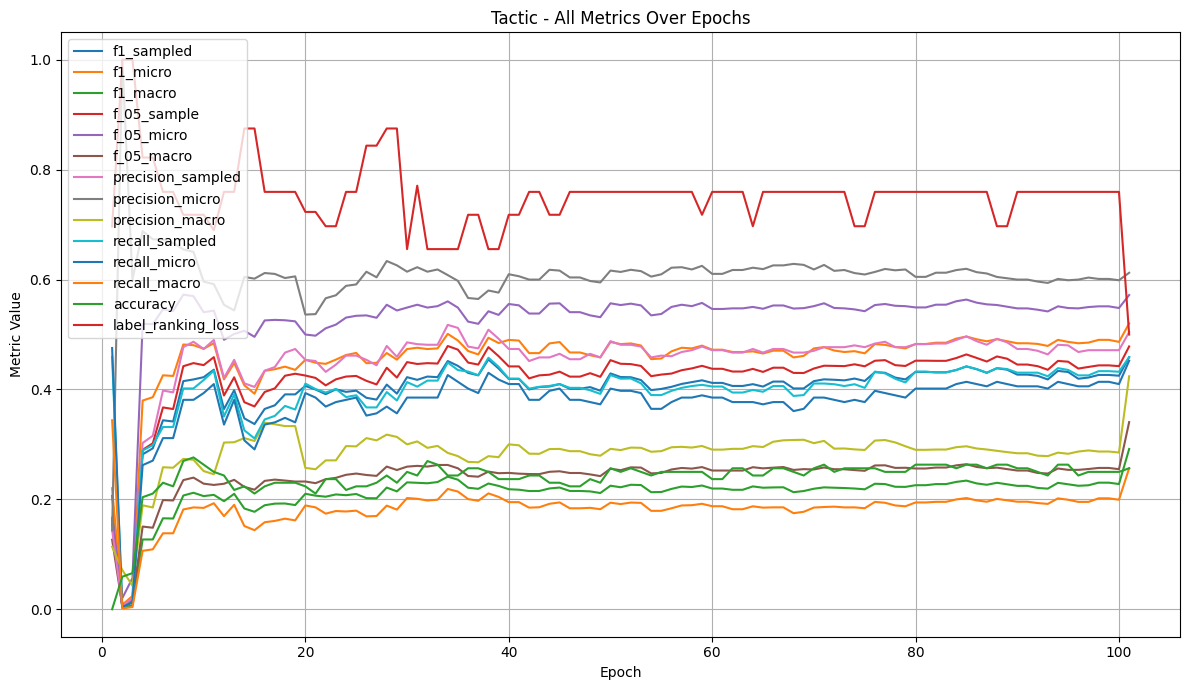

In [44]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    print(f"{metric_name}: {len(values)}")
    if metric_name != 'lrap' and metric_name != 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic - All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

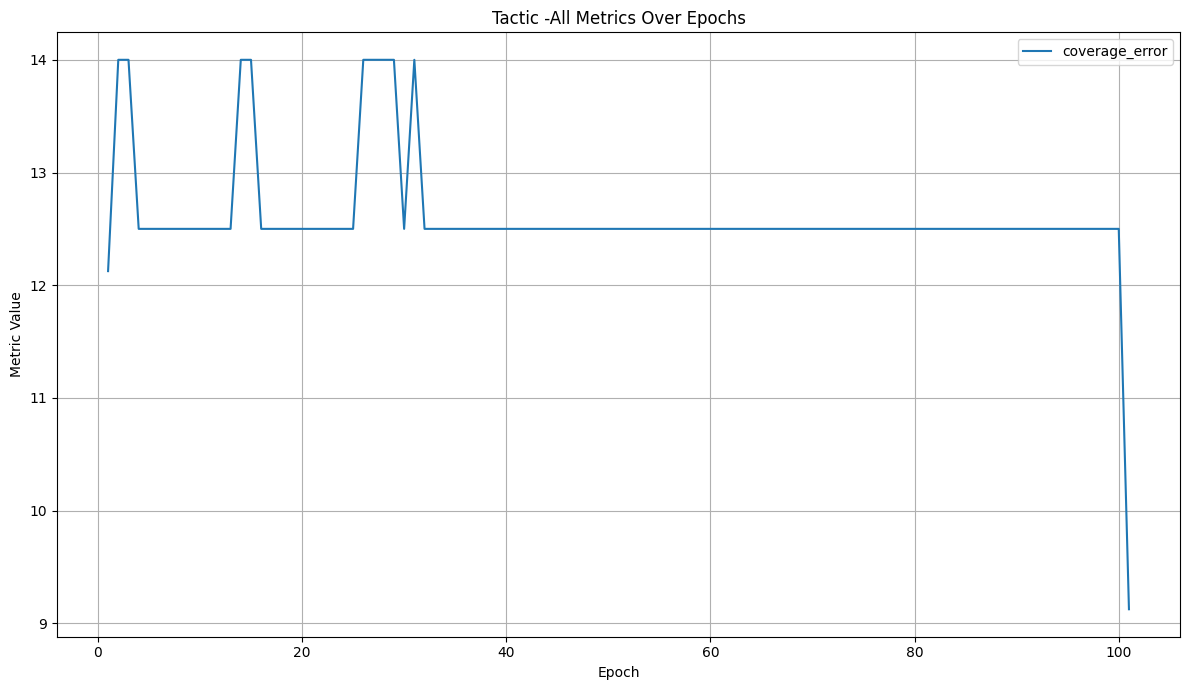

In [45]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

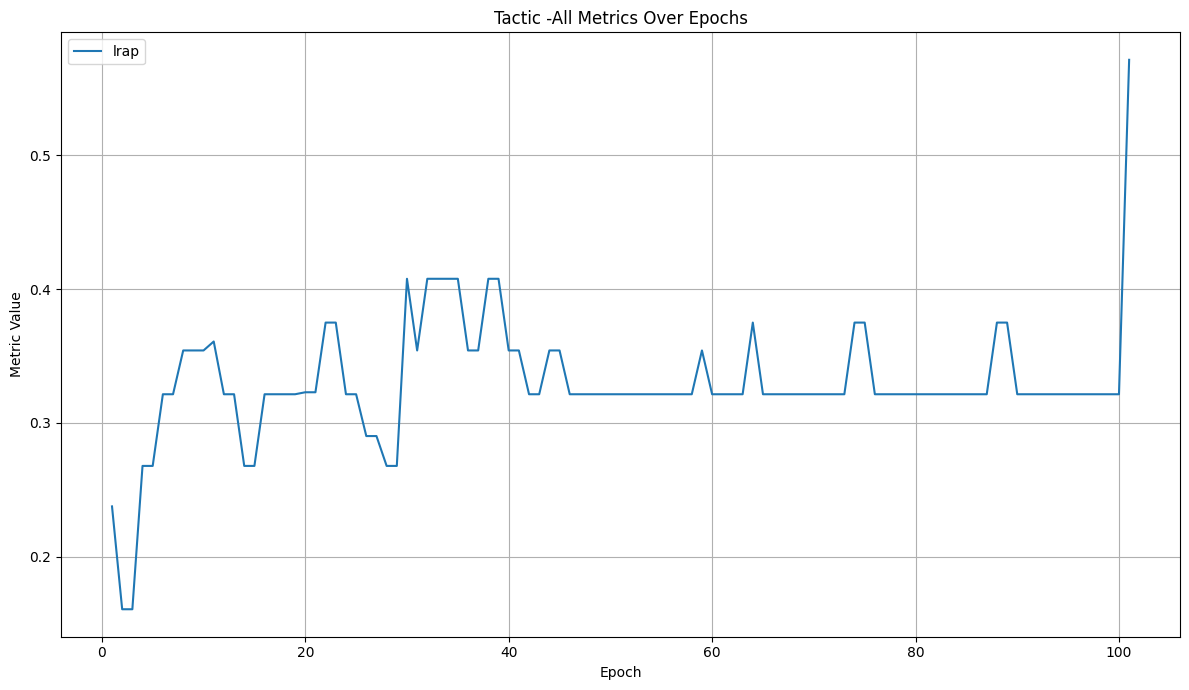

In [46]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'lrap':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [48]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[0:14].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

In [49]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  for col in sorted_results.columns[:limit]:
        print(f"{col}: {sorted_results[col].values[0]}")

  return sorted_results.iloc[:, :limit]

In [50]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df['text_clean'] = df['Text'].map(lambda t: preprocess(t))


train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)


In [51]:
print("------Validation results --------")
print(BEST_F1)

print("F1 scores per class")
y_train_df = train.drop(train.columns[0:2], axis=1)

f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, test.columns[2:16], 14)
print("----------------------------------")

print("Recall scores per class")
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, test.columns[2:16], 14)
print("----------------------------------")

print("Precision scores per class")
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, test.columns[2:16], 14)
print("----------------------------------")

print("Accuracy scores per class")
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, test.columns[2:16], 14)

------Validation results --------
0.4654444548041869
F1 scores per class
TA0040: 0.75
TA0002: 0.5825242718446602
TA0009: 0.5614035087719298
TA0006: 0.5333333333333333
TA0004: 0.43478260869565216
TA0001: 0.4166666666666667
TA0005: 0.1
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Recall scores per class
TA0040: 0.75
TA0009: 0.5714285714285714
TA0002: 0.5660377358490566
TA0006: 0.4444444444444444
TA0004: 0.3448275862068966
TA0001: 0.32608695652173914
TA0005: 0.0625
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Precision scores per class
TA0040: 0.75
TA0006: 0.6666666666666666
TA0002: 0.6
TA0004: 0.5882352941176471
TA0001: 0.5769230769230769
TA0009: 0.5517241379310345
TA0005: 0.25
TA0003: 0.0
TA0008: 0.0
TA0007: 0.0
TA0010: 0.0
TA0011: 0.0
TA0042: 0.0
TA0043: 0.0
----------------------------------
Accuracy scores per class
TA0001: 0.243421052631

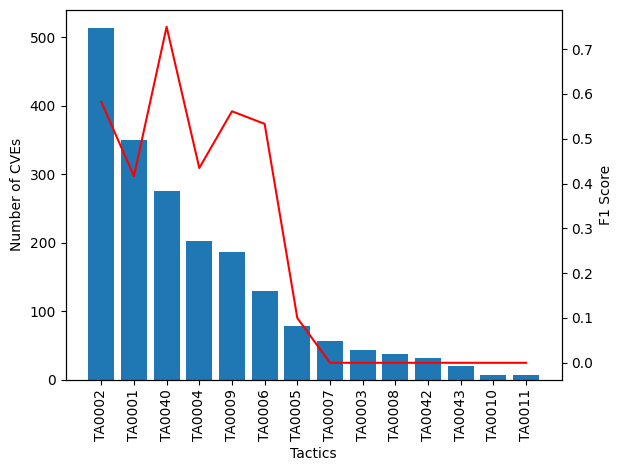

In [52]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])

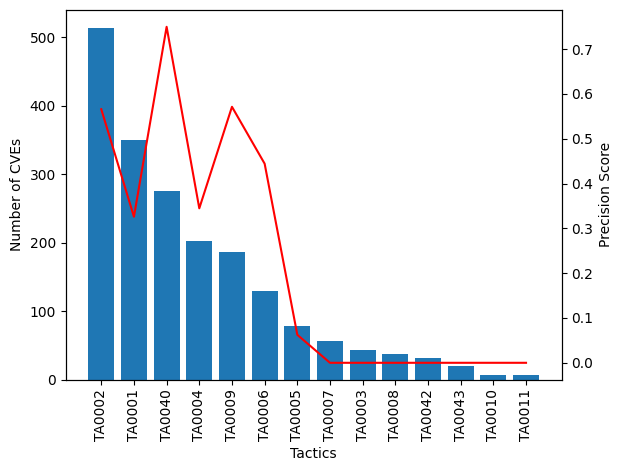

In [53]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[2:16])